# 🧠 Deepfake Detection using CNN (FakeAVCeleb v1.2 - 4-Class Classification)
This notebook trains a CNN to classify FakeAVCeleb_v1.2 videos into 4 categories:
- RealVideo-RealAudio
- RealVideo-FakeAudio
- FakeVideo-RealAudio
- FakeVideo-FakeAudio

It includes efficient preprocessing with on-disk batch caching and a **90/10 train-validation split**.

In [2]:

import os
import numpy as np
import cv2
import gc
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:

# ===== CONFIGURATION =====
dataset_dir = "FakeAVCeleb_v1.2"
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 80
categories = ["RealVideo-RealAudio", "RealVideo-FakeAudio", "FakeVideo-RealAudio", "FakeVideo-FakeAudio"]
CASCADE_PATH = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"

os.makedirs("cache_batches", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [4]:

def load_and_preprocess_dataset(dataset_dir, img_size=128, batch_size=2000):
    X, y = [], []
    face_detector = cv2.CascadeClassifier(CASCADE_PATH)
    batch_index = 0

    for label in categories:
        folder_path = os.path.join(dataset_dir, label)
        print(f"Processing {label}...")

        for root, _, files in os.walk(folder_path):
            for file in tqdm(files):
                if not file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                    continue

                video_path = os.path.join(root, file)
                cap = cv2.VideoCapture(video_path)
                frame_count = 0

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    if frame_count % 15 == 0:
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        faces = face_detector.detectMultiScale(gray, 1.3, 5)
                        for (x, y1, w, h) in faces:
                            face = frame[y1:y1+h, x:x+w]
                            face = cv2.resize(face, (img_size, img_size))
                            X.append(face.astype(np.float32) / 255.0)
                            y.append(label)
                            break
                    frame_count += 1
                cap.release()

                # Save batch
                if len(X) >= batch_size:
                    np.savez_compressed(f"cache_batches/batch_{batch_index}.npz",
                                        X=np.array(X, dtype=np.float32), y=np.array(y))
                    print(f"✅ Saved batch_{batch_index}.npz ({len(X)} samples)")
                    X, y = [], []
                    batch_index += 1
                    gc.collect()

    # Save last batch
    if len(X) > 0:
        np.savez_compressed(f"cache_batches/batch_{batch_index}.npz",
                            X=np.array(X, dtype=np.float32), y=np.array(y))
        print(f"✅ Saved final batch_{batch_index}.npz")

    print("✅ All batches saved in cache_batches/ folder")


In [5]:

def batch_generator(cache_folder="cache_batches", batch_size=32, val_split=0.1):
    cache_files = sorted(glob.glob(f"{cache_folder}/batch_*.npz"))
    print(f"🔄 Streaming {len(cache_files)} cached batches from disk...")

    for cache_file in cache_files:
        data = np.load(cache_file, allow_pickle=True)
        X, y = data["X"], data["y"]
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        y_encoded = np.eye(len(categories))[y_encoded]

        # Shuffle and split
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * (1 - val_split))
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        yield (X[train_idx], y_encoded[train_idx]), (X[val_idx], y_encoded[val_idx])
        del data


In [6]:

# ===== MODEL DEFINITION =====
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(4, activation="softmax")
])

model.compile(optimizer=Adam(0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\rahul\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,241,796 (20.00 MB)

 Trainable params: 5,240,836 (19.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:

# ===== TRAINING =====
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

train_gen = batch_generator("cache_batches", batch_size=BATCH_SIZE, val_split=0.1)

print("\n🚀 Starting training on streamed batches...")

for (X_train, y_train), (X_val, y_val) in train_gen:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop, lr_reduce],
        verbose=1
    )
    gc.collect()



🚀 Starting training on streamed batches...
🔄 Streaming 74 cached batches from disk...
Epoch 1/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9828 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 0.3931 - learning_rate: 3.0000e-04
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - accuracy: 1.0000 - loss: 8.6960e-07 - val_accuracy: 1.0000 - val_loss: 3.7539e-04 - learning_rate: 3.0000e-04
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 293ms/step - accuracy: 1.0000 - loss: 7.5331e-09 - val_accuracy: 1.0000 - val_loss: 4.9819e-07 - learning_rate: 3.0000e-04
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 1.0000 - loss: 5.1871e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 1.0000 - loss: 3.0331e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 1.0000 - loss: 2.6960e-09
Epoch 

In [8]:

# ===== SAVE MODEL =====
model.save("outputs/cnn_fakeavceleb_streamsplit.h5")
print("✅ Model saved at outputs/cnn_fakeavceleb_streamsplit.h5")


✅ Model saved at outputs/cnn_fakeavceleb_streamsplit.h5


🔄 Loading trained model...
✅ Model loaded successfully!
📊 Collecting validation data from 74 batches...
📈 Total validation samples: 14804
🔍 Unique labels in validation data: ['FakeVideo-FakeAudio' 'FakeVideo-RealAudio' 'RealVideo-FakeAudio'
 'RealVideo-RealAudio']
🔍 Expected categories: ['RealVideo-RealAudio', 'RealVideo-FakeAudio', 'FakeVideo-RealAudio', 'FakeVideo-FakeAudio']
🎯 Making predictions...
463/463 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step
🔍 Unique true labels: [0 1 2 3]
🔍 Unique predicted labels: [0]
🔍 Shape of y_pred_proba: (14804, 4)

📊 PERFORMANCE METRICS
Accuracy: 0.4481
Precision: 0.2008
Recall: 0.4481
F1-Score: 0.2773

📋 DETAILED CLASSIFICATION REPORT
Present classes in data: [0 1 2 3]
Present categories: ['RealVideo-RealAudio', 'RealVideo-FakeAudio', 'FakeVideo-RealAudio', 'FakeVideo-FakeAudio']
                     precision    recall  f1-score   support

RealVideo-RealAudio       0.45      1.00      0.62      6634
RealVideo-FakeAudio       0.00      0.00      0.00      73

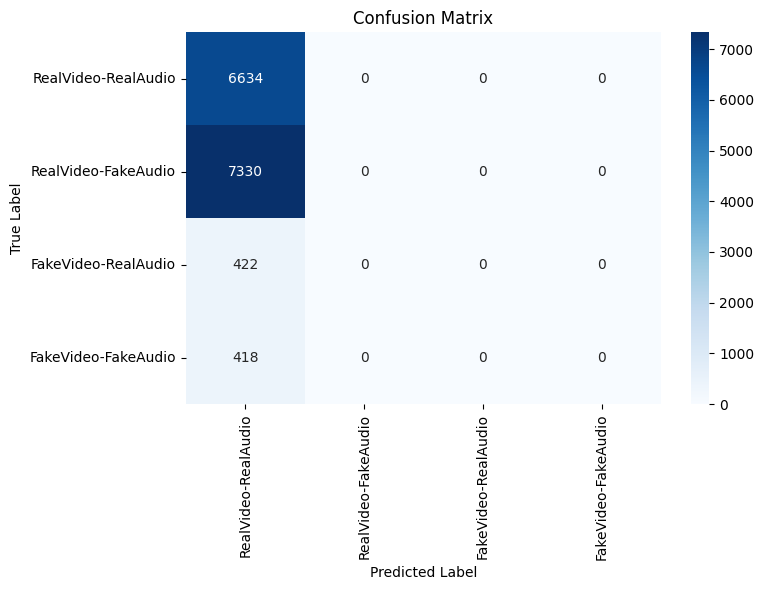


📈 ROC-AUC CURVES


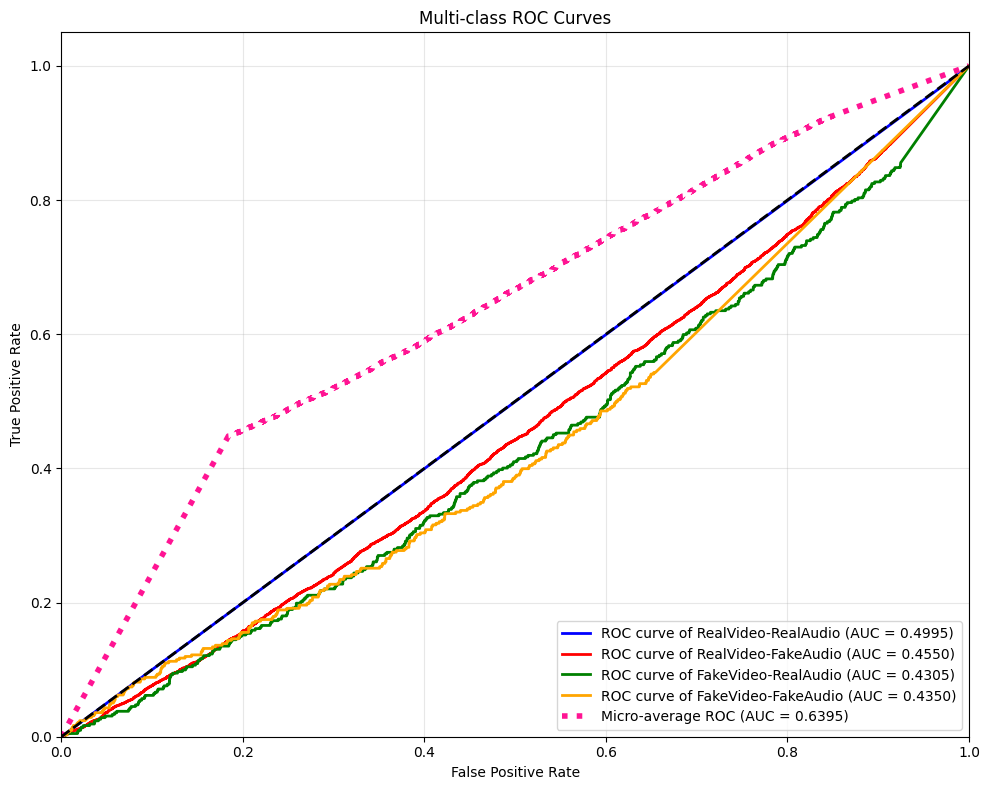


AUC Scores for each class:
RealVideo-RealAudio: 0.4995
RealVideo-FakeAudio: 0.4550
FakeVideo-RealAudio: 0.4305
FakeVideo-FakeAudio: 0.4350
Micro-average AUC: 0.6395

👀 SAMPLE PREDICTIONS VISUALIZATION


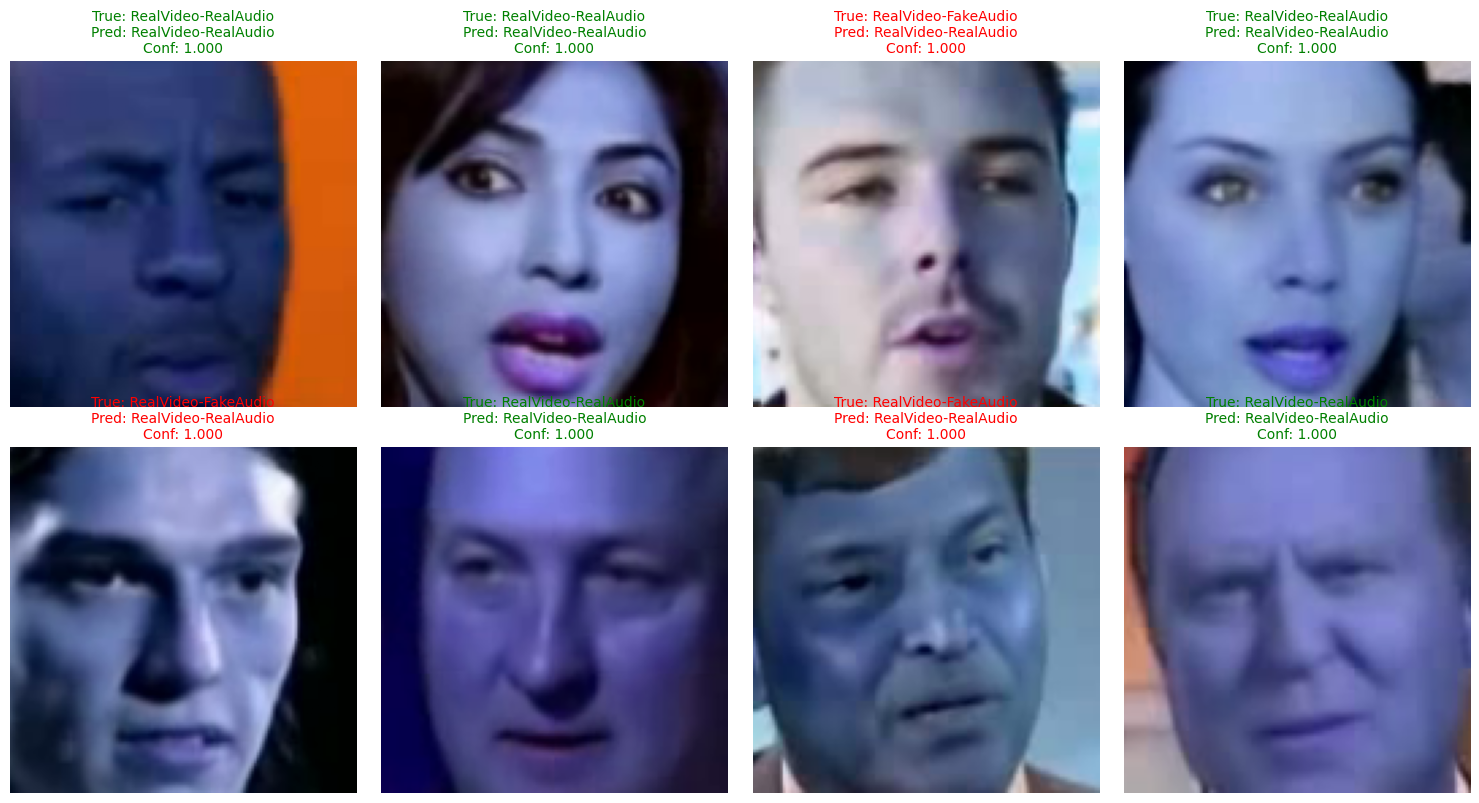


✅ All evaluation completed! Check the 'outputs' folder for saved plots.
📁 Generated files:
   - confusion_matrix.png
   - roc_curves.png
   - sample_predictions.png


In [16]:
# ===== MODEL EVALUATION AND METRICS =====
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import os

# Load the saved model
from tensorflow.keras.models import load_model

print("🔄 Loading trained model...")
model = load_model("outputs/cnn_fakeavceleb_streamsplit.h5")
print("✅ Model loaded successfully!")

# Define categories (same as in training)
categories = ["RealVideo-RealAudio", "RealVideo-FakeAudio", "FakeVideo-RealAudio", "FakeVideo-FakeAudio"]

# Function to collect all validation data from cached batches
def collect_validation_data(cache_folder="cache_batches", val_split=0.1):
    cache_files = sorted(glob.glob(f"{cache_folder}/batch_*.npz"))
    X_val_all, y_val_all = [], []
    y_labels_all = []  # Store original labels for debugging
    
    print(f"📊 Collecting validation data from {len(cache_files)} batches...")
    
    for cache_file in cache_files:
        data = np.load(cache_file, allow_pickle=True)
        X, y = data["X"], data["y"]
        
        # Store original labels for debugging
        y_labels_all.extend(y)
        
        # Encode labels - use the same categories as defined
        le = LabelEncoder()
        le.fit(categories)  # Fit on all expected categories
        y_encoded = le.transform(y)  # Transform current batch
        y_encoded = np.eye(len(categories))[y_encoded]
        
        # Split to get validation data only
        indices = np.arange(len(X))
        np.random.seed(42)  # For reproducibility
        np.random.shuffle(indices)
        split_idx = int(len(indices) * (1 - val_split))
        val_idx = indices[split_idx:]
        
        X_val_all.append(X[val_idx])
        y_val_all.append(y_encoded[val_idx])
        
        del data
    
    # Concatenate all validation data
    X_val_combined = np.concatenate(X_val_all, axis=0)
    y_val_combined = np.concatenate(y_val_all, axis=0)
    
    print(f"📈 Total validation samples: {len(X_val_combined)}")
    
    # Debug: Check unique labels in validation set
    unique_labels = np.unique([label for label in y_labels_all])
    print(f"🔍 Unique labels in validation data: {unique_labels}")
    print(f"🔍 Expected categories: {categories}")
    
    return X_val_combined, y_val_combined

# Collect validation data
X_val, y_val = collect_validation_data()

# Make predictions
print("🎯 Making predictions...")
y_pred_proba = model.predict(X_val, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

# Debug information
print(f"🔍 Unique true labels: {np.unique(y_true)}")
print(f"🔍 Unique predicted labels: {np.unique(y_pred)}")
print(f"🔍 Shape of y_pred_proba: {y_pred_proba.shape}")

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n" + "="*50)
print("📊 PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report - handle case where not all classes are present
print("\n" + "="*50)
print("📋 DETAILED CLASSIFICATION REPORT")
print("="*50)

# Get the actual labels present in the data
present_labels = np.unique(np.concatenate([y_true, y_pred]))
present_categories = [categories[i] for i in present_labels if i < len(categories)]

print(f"Present classes in data: {present_labels}")
print(f"Present categories: {present_categories}")

# Use labels parameter to specify which classes to include in report
print(classification_report(y_true, y_pred, 
                          labels=present_labels,
                          target_names=present_categories,
                          zero_division=0))

# Confusion Matrix
print("\n" + "="*50)
print("🎯 CONFUSION MATRIX")
print("="*50)

# Create confusion matrix with all expected classes
cm = confusion_matrix(y_true, y_pred, labels=range(len(categories)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve and AUC - only for present classes
print("\n" + "="*50)
print("📈 ROC-AUC CURVES")
print("="*50)

# Only compute ROC for classes that are actually present
present_labels = np.unique(y_true)
n_present_classes = len(present_labels)

if n_present_classes > 1:
    # Binarize the output for ROC curve
    y_val_bin = label_binarize(y_true, classes=range(len(categories)))
    
    # Compute ROC curve and ROC area for each present class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in present_labels:
        if i < len(categories):  # Ensure index is within bounds
            fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Plot each present class
    for i, color in zip(present_labels, colors):
        if i < len(categories):  # Ensure index is within bounds
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of {0} (AUC = {1:0.4f})'
                     ''.format(categories[i], roc_auc[i]))
    
    # Plot micro-average
    plt.plot(fpr["micro"], tpr["micro"],
             color='deeppink', linestyle=':', linewidth=4,
             label='Micro-average ROC (AUC = {0:0.4f})'
             ''.format(roc_auc["micro"]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('outputs/roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print AUC scores
    print("\nAUC Scores for each class:")
    for i in present_labels:
        if i < len(categories):
            print(f"{categories[i]}: {roc_auc[i]:.4f}")
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
else:
    print("⚠️  Not enough classes present for ROC curve analysis")

# Sample predictions visualization
print("\n" + "="*50)
print("👀 SAMPLE PREDICTIONS VISUALIZATION")
print("="*50)

# Display some sample predictions
def display_sample_predictions(X, y_true, y_pred, y_pred_proba, categories, num_samples=8):
    indices = np.random.choice(len(X), min(num_samples, len(X)), replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        if i < len(indices):
            axes[i].imshow(X[idx])
            true_label = categories[y_true[idx]] if y_true[idx] < len(categories) else f"Class {y_true[idx]}"
            pred_label = categories[y_pred[idx]] if y_pred[idx] < len(categories) else f"Class {y_pred[idx]}"
            confidence = np.max(y_pred_proba[idx])
            
            color = 'green' if y_true[idx] == y_pred[idx] else 'red'
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                             color=color, fontsize=10)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

display_sample_predictions(X_val, y_true, y_pred, y_pred_proba, categories)

print("\n✅ All evaluation completed! Check the 'outputs' folder for saved plots.")
print("📁 Generated files:")
print("   - confusion_matrix.png")
print("   - roc_curves.png") 
print("   - sample_predictions.png")